In [12]:
import pandas as pd
import os
import csv
import ast
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Use 30 snapshots version of training file for now because it is much faster

In [13]:
data = pd.read_csv('../../Preprocess/GadgetX-NewMDCLUSTER-1/progenitor-pair/30 snapshots/training_data.csv')

---

# Feature Importance from Tree-based models

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [15]:
filtered_data = data[['numSubStruct', 'Mvir', 'npart', 'Xc', 'Yc', 'Zc', 'VXc', 'VYc', 'VZc', 'Rvir', 'Rmax', 'r2', 
                      'mbp_offset', 'com_offset', 'Vmax', 'v_esc', 'sigV', 'lambda', 'lambdaE', 'Lx', 'Ly', 'Lz', 'b', 'c', 'Eax',
                      'Eay', 'Eaz', 'Ebx', 'Eby', 'Ebz', 'Ecx', 'Ecy', 'Ecz', 'ovdens', 'nbins', 'fMhires', 'Ekin', 'Epot', 'SurfP',
                      'Phi0', 'cNFW', 'numProgenitors', 'redshift', 'snapshot', 
                      'progenitor_numSubStruct', 'progenitor_Mvir', 'progenitor_npart', 'progenitor_Xc', 'progenitor_Yc', 
                      'progenitor_Zc', 'progenitor_VXc', 'progenitor_VYc', 'progenitor_VZc', 'progenitor_Rvir', 'progenitor_Rmax',
                      'progenitor_r2', 'progenitor_mbp_offset', 'progenitor_com_offset', 'progenitor_Vmax', 'progenitor_v_esc', 
                      'progenitor_sigV', 'progenitor_lambda', 'progenitor_lambdaE', 'progenitor_Lx', 'progenitor_Ly', 'progenitor_Lz', 
                      'progenitor_b', 'progenitor_c', 'progenitor_Eax', 'progenitor_Eay', 'progenitor_Eaz', 'progenitor_Ebx',
                      'progenitor_Eby', 'progenitor_Ebz', 'progenitor_Ecx', 'progenitor_Ecy', 'progenitor_Ecz', 'progenitor_ovdens',
                      'progenitor_nbins', 'progenitor_fMhires', 'progenitor_Ekin', 'progenitor_Epot', 'progenitor_SurfP', 
                      'progenitor_Phi0', 'progenitor_cNFW', 'progenitor_numProgenitors', 
                      'progenitor_redshift', 'progenitor_snapshot', 'rel_location','rel_velocity','Is_Progenitor']]

In [16]:
# Splitting the data into features and target variable
X_filtered = filtered_data.drop('Is_Progenitor', axis=1)
y_filtered = filtered_data['Is_Progenitor']

# Splitting the data into training and testing sets
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_filtered_scaled = scaler.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler.transform(X_test_filtered)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_filtered_scaled, y_train_filtered)

# Get feature importances
feature_importances_filtered = rf.feature_importances_
feature_names_filtered = X_train_filtered.columns

# Create a DataFrame for the importances and sort it
importances_df_filtered = pd.DataFrame({
    'Feature': feature_names_filtered,
    'Importance': feature_importances_filtered
}).sort_values(by='Importance', ascending=False)

importances_df_filtered.head(10)  # Displaying top 10 features based on importance

,Feature,Importance
88,rel_location,0.347837
89,rel_velocity,0.264440
43,snapshot,0.084687
86,progenitor_redshift,0.067329
87,progenitor_snapshot,0.055632
42,redshift,0.038609
41,numProgenitors,0.016833
59,progenitor_v_esc,0.006697
37,Epot,0.005841
1,Mvir,0.005779


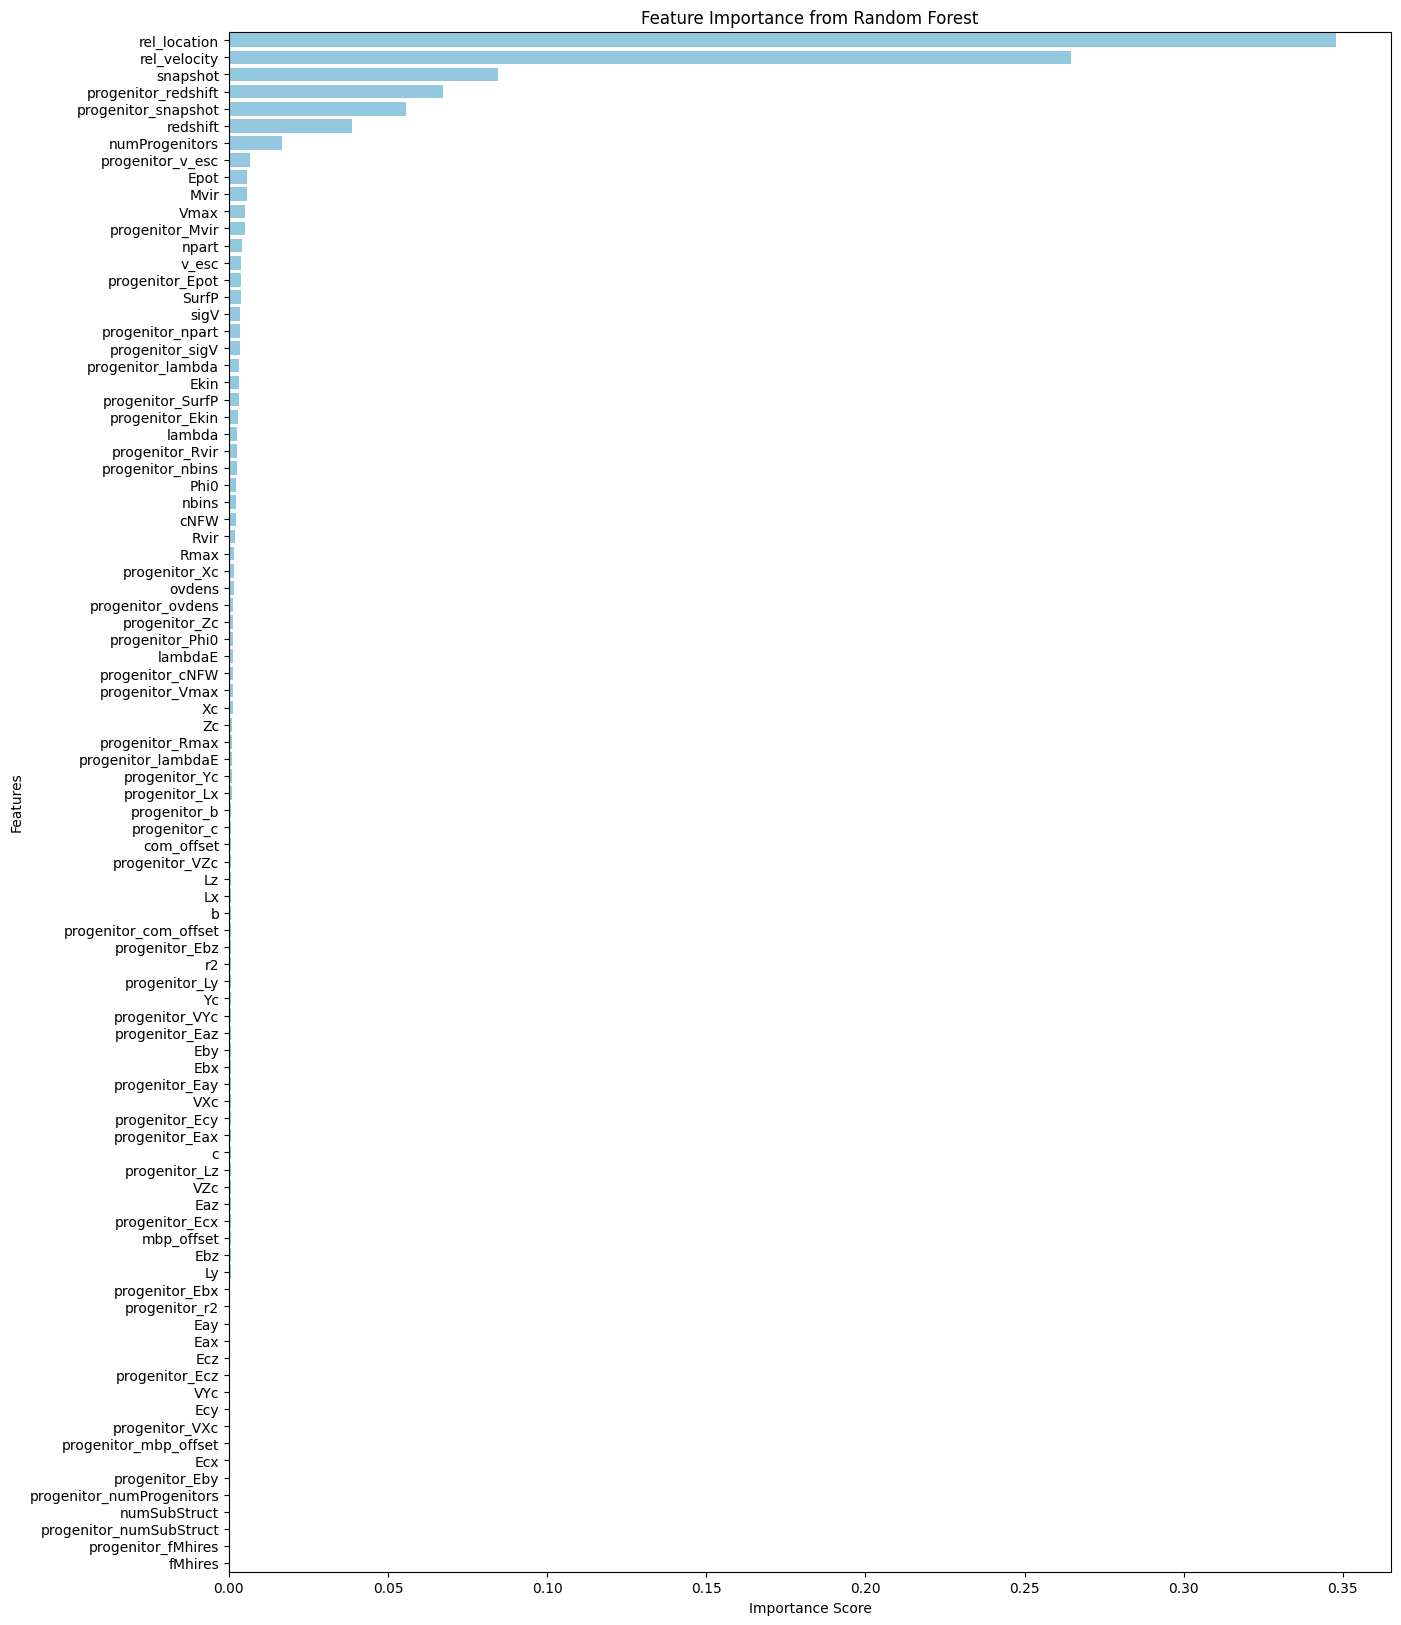

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the feature importances
plt.figure(figsize=(15, 20))
sns.barplot(x=importances_df_filtered['Importance'], y=importances_df_filtered['Feature'], color='skyblue')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


___

# Correlation-based Feature Selection (CFS)

- Features that are highly correlated with the target variable are favored.

- Features that are highly correlated with other features (redundant) are penalized, as they don't add much new information.

In [18]:
# Compute the correlation matrix
correlation_matrix = filtered_data.corr()

# Extract correlations with the target variable
target_correlation = correlation_matrix["Is_Progenitor"].drop("Is_Progenitor")

# Sort by absolute value
sorted_target_correlation = target_correlation.abs().sort_values(ascending=False)

sorted_target_correlation

rel_location                 0.812146
rel_velocity                 0.804143
snapshot                     0.580439
progenitor_snapshot          0.580439
redshift                     0.569122
                               ...   
progenitor_numProgenitors    0.003278
progenitor_Eby               0.002693
Ecz                          0.000713
Eby                          0.000505
progenitor_VXc               0.000018
Name: Is_Progenitor, Length: 90, dtype: float64

Find the best threshhold

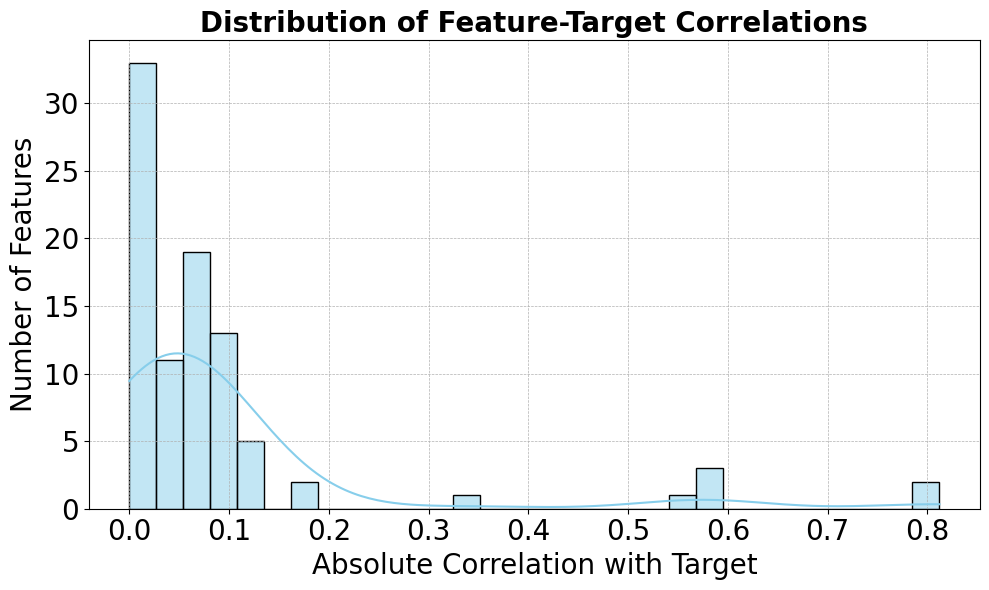

In [19]:
# Plotting the distribution of feature-to-target correlations
plt.figure(figsize=(10, 6))
sns.histplot(sorted_target_correlation.abs(), bins=30, kde=True, color='skyblue')

# Title and labels
plt.title('Distribution of Feature-Target Correlations', fontsize=20, fontweight='bold')
plt.xlabel('Absolute Correlation with Target', fontsize=20)
plt.ylabel('Number of Features', fontsize=20)

# Adjusting tick sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

- A large number of features have correlations close to 0, which means little to no linear relationship with Is_Progenitor.

Fine tune thresholds

In [31]:
from sklearn.model_selection import cross_val_score

# Define a range of thresholds
thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3]
accuracies = []

# For each threshold, select features and evaluate model performance using cross-validation
for threshold in thresholds:
    selected = sorted_target_correlation[sorted_target_correlation.abs() > threshold].index.tolist()
    X_threshold = X_filtered[selected]
    # Normalize the data
    X_threshold_scaled = scaler.fit_transform(X_threshold)
    # Using cross-validation to get accuracy
    accuracy = cross_val_score(rf, X_threshold_scaled, y_filtered, cv=5, scoring='accuracy').mean()
    accuracies.append(accuracy)


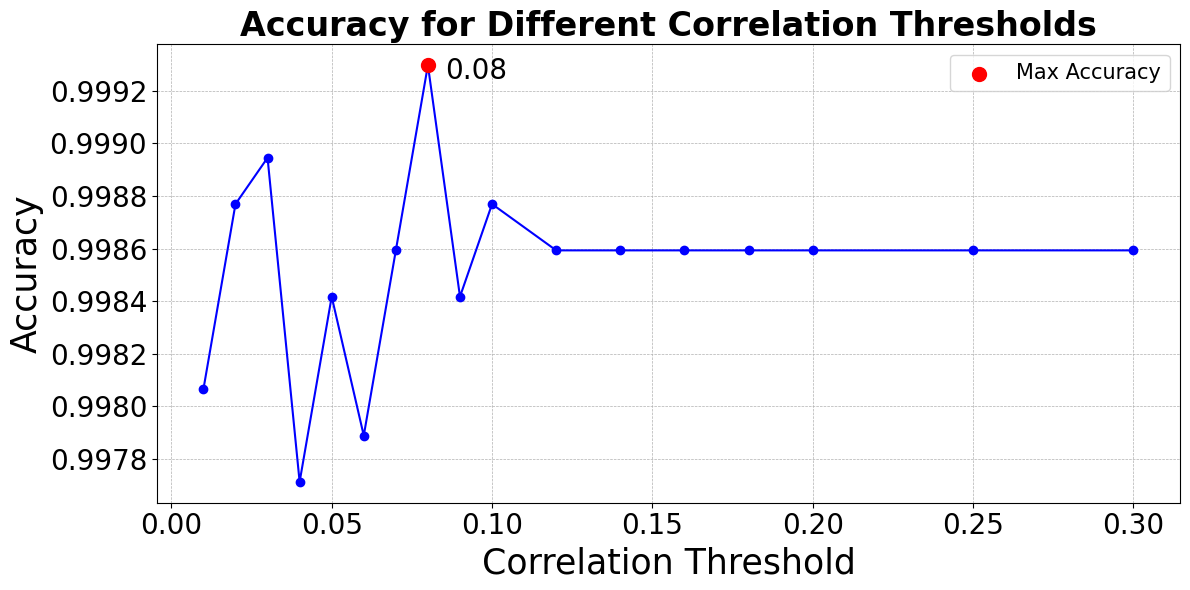

In [61]:
max_accuracy = max(accuracies)
max_index = accuracies.index(max_accuracy)
max_threshold = thresholds[max_index]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color='b')

# Highlight the point with the highest accuracy
plt.scatter(max_threshold, max_accuracy, color='r', s=100, zorder=5, label='Max Accuracy')

# Annotate the highlighted point with its accuracy value
plt.annotate(f'{max_threshold:.2f}', (max_threshold, max_accuracy), textcoords="offset points", xytext=(35,-10), ha='center', fontsize=20)

# Setting the title, x and y labels with specified font sizes and weights
plt.title('Accuracy for Different Correlation Thresholds', fontweight='bold', fontsize=24)
plt.xlabel('Correlation Threshold', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

0.08 has the highest accuracy

we use 0.08 as the threshold

In [11]:
# Adjusting the threshold for selecting features based on their correlation with the target to 0.08
selected_features = sorted_target_correlation[sorted_target_correlation.abs() > 0.08].index.tolist()

# Removing features that are highly correlated with each other
for feature in selected_features:
    if feature not in sorted_target_correlation.index:
        continue  # The feature was already removed due to high correlation with another feature
    high_corr_features = correlation_matrix[feature][selected_features].drop(feature)
    redundant_features = high_corr_features[high_corr_features.abs() > 0.8].index.tolist()
    for redundant_feature in redundant_features:
        if sorted_target_correlation[feature] > sorted_target_correlation[redundant_feature]:
            selected_features.remove(redundant_feature)
        else:
            selected_features.remove(feature)
            break  # Exit inner loop if the feature was removed

selected_features

['rel_location',
 'rel_velocity',
 'progenitor_snapshot',
 'progenitor_redshift',
 'numProgenitors',
 'cNFW',
 'lambda',
 'progenitor_lambda',
 'Rmax',
 'nbins',
 'progenitor_nbins',
 'progenitor_com_offset',
 'r2',
 'progenitor_SurfP',
 'ovdens',
 'SurfP',
 'progenitor_cNFW',
 'com_offset']

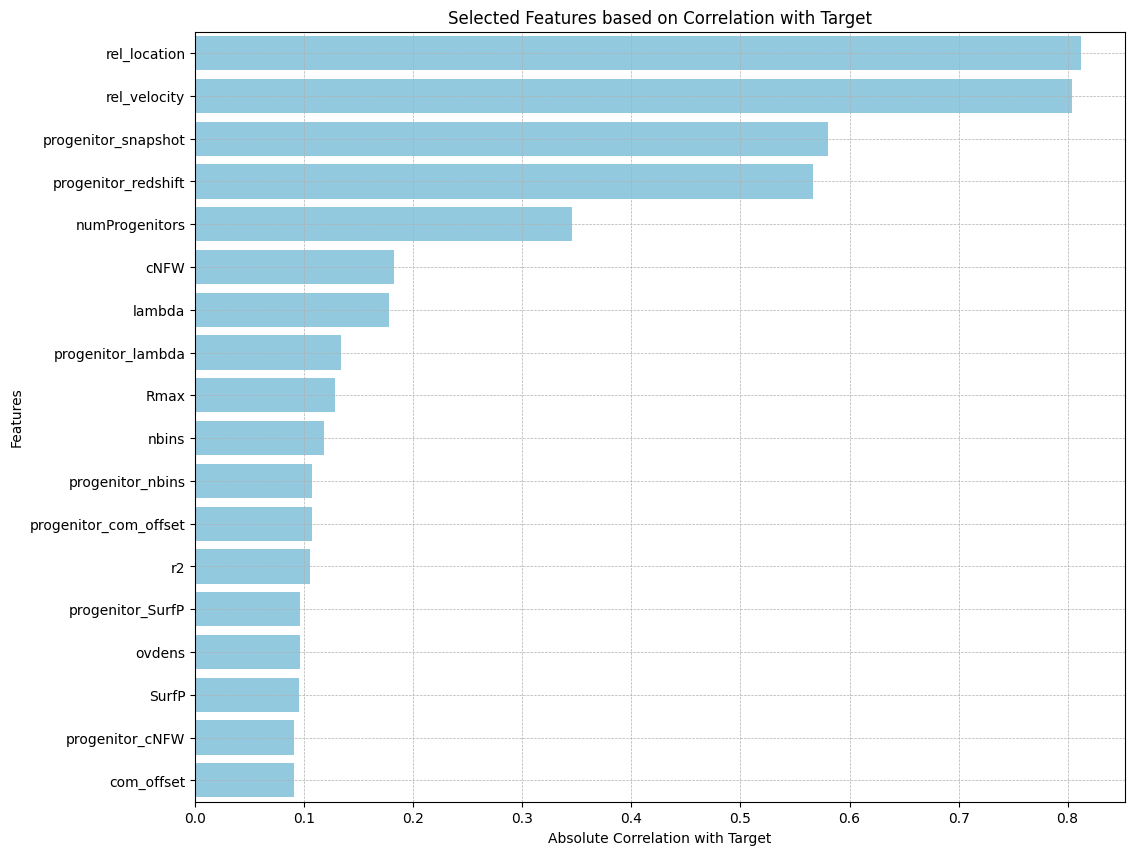

In [12]:
# Extracting the correlation values for the selected features
selected_correlations = sorted_target_correlation[selected_features]

# Sorting the features by their absolute correlation values
sorted_selected_correlations = selected_correlations.abs().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_selected_correlations, y=sorted_selected_correlations.index, color='skyblue')
plt.title('Selected Features based on Correlation with Target')
plt.xlabel('Absolute Correlation with Target')
plt.ylabel('Features')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()
